In [1]:
import numpy as np
import numpy.linalg as lin
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy
from cvxpy import Variable, Minimize, Problem, sum_squares, quad_form
import sklearn
from sklearn.svm import SVC
from sklearn.cluster import KMeans
%matplotlib inline
%precision 5
np.set_printoptions(precision=5)

# Regularization
## Tasks 7-10

In [2]:
f_train = np.loadtxt('features.train.txt')
f_test = np.loadtxt('features.test.txt')

In [3]:
def quad_transform(x):
    x1, x2 = x[:,1], x[:,2]
    ones = np.ones(len(x))
    return np.c_[ones, x1, x2, x1*x2, x1**2, x2**2]

def _split1_one_vs_all(f, digit, transform):
    f_digits = np.floor(f[:,0])
    c = f_digits == digit
    x = np.c_[np.ones(len(f)), f[:,1:]]
    y = np.where(c, [+1.0], [-1.0])
    if transform:
        x = quad_transform(x)
    return x, y

def split2_one_vs_all(digit, transform):
    x_train, y_train = _split1_one_vs_all(f_train, digit, transform)
    x_test, y_test = _split1_one_vs_all(f_test, digit, transform)
    return x_train, y_train, x_test, y_test

def _errs1_inout(w, x, y):
    return np.mean(np.sign(x @ w) != y)

def errs2_inout(w, x_train, y_train, x_test, y_test):
    return (_errs1_inout(w, x_train, y_train),
            _errs1_inout(w, x_test, y_test))

def solve_cvxpy(x, y, lamb):
    n, m = x.shape
    w_ = Variable(m)
    obj = 1/n * sum_squares(x @ w_ - y) + lamb/n * sum_squares(w_)
    prob = Problem(Minimize(obj))
    prob.solve()
    assert prob.status == 'optimal'
    w_cx = np.array(w_.value).squeeze(1)
    return w_cx

def solve_linalg(x, y, lamb):
    n, m = x.shape
    w = np.linalg.inv(x.T @ x + lamb * np.eye(m)) @ x.T @ y
    return w

def solve_one_vs_all(digit, lamb, transform, cvxpy=False):
    x, y, x_test, y_test = split2_one_vs_all(digit, transform)
    w = solve_linalg(x, y, lamb)
    if cvxpy:
        assert np.allclose(solve_cvxpy(x, y, lamb), w)
    return errs2_inout(w, x, y, x_test, y_test)

def _split1_one_vs_one(f, dig1, dig2, transform):
    d_all = np.floor(f[:,0])
    c_all = np.logical_or(d_all == dig1, d_all == dig2)
    f_filt = f[c_all]
    d_filt = np.floor(f_filt[:,0])
    c_filt = d_filt == dig1
    y = np.where(c_filt, [+1.0], [-1.0])
    x = np.c_[np.ones(len(f_filt)), f_filt[:,1:]]
    if transform:
        x = quad_transform(x)
    return x, y

def split2_one_vs_one(dig1, dig2, transform):
    x_train, y_train = _split1_one_vs_one(f_train, dig1, dig2, transform)
    x_test, y_test = _split1_one_vs_one(f_test, dig1, dig2, transform)
    return x_train, y_train, x_test, y_test

def solve_one_vs_one(dig1, dig2, lamb, transform=True, cvxpy=False):
    x, y, x_test, y_test = split2_one_vs_one(dig1, dig2, transform)
    w = solve_linalg(x, y, lamb)
    if cvxpy:
        max_err = cvxpy
        if not isinstance(max_err, float):
            max_err = 0.001
        w_cx = solve_cvxpy(x, y, lamb)
        rel_err = lin.norm(w_cx-w) / lin.norm(w)
        if rel_err > max_err:
            print('! cvxpy relative error %.2f' % rel_err)
        if str(cvxpy) == 'force':
            w = w_cx
    return errs2_inout(w, x, y, x_test, y_test)

#### Task 7

In [4]:
for digit in (5,6,7,8,9):
    ein, eout = solve_one_vs_all(digit, lamb=1., transform=False)
    print('digit:{:d} Ein:{:.4f}'.format(digit, ein))

digit:5 Ein:0.0763
digit:6 Ein:0.0911
digit:7 Ein:0.0885
digit:8 Ein:0.0743
digit:9 Ein:0.0883


#### Task 8

In [5]:
for digit in (0,1,2,3,4):
    ein, eout = solve_one_vs_all(digit, lamb=1., transform=True)
    print('digit:{:d} Eout:{:.4f}'.format(digit, eout))

digit:0 Eout:0.1066
digit:1 Eout:0.0219
digit:2 Eout:0.0987
digit:3 Eout:0.0827
digit:4 Eout:0.0997


#### Task 9

In [6]:
def task9():
    all_errs = []
    for dig in range(10):
        # Err_in & Err_out for Q=2 and Q=5
        # E2 - NO transform, E5 - USE transform
        i2, o2 = solve_one_vs_all(dig, lamb=1., transform=False)
        i5, o5 = solve_one_vs_all(dig, lamb=1., transform=True)
        all_errs.append((i2, o2, i5, o5))
    print('a')
    for dig in range(10):
        i2, o2, i5, o5 = all_errs[dig]
        print('a {} Ei5-Ei2:{:8.5f} Eo5-Eo2:{:8.5f} overfit:{:d}'
              .format(dig, i5-i2, o5-o2, i5-i2<0 and o5-o2>0))
    print('\nb/d')
    for dig in range(10):
        i2, o2, i5, o5 = all_errs[dig]
        print('b {} improve 2->5:{:>5.2f}%'
              .format(dig, -(o5-o2)/o2*100))
    print('\nc')
    for dig in range(10):
        i2, o2, i5, o5 = all_errs[dig]
        print('c {} Eo2:{:7.4f} Eo5:{:7.4f} Eo2-Eo5:{:8.5f}'
              .format(dig, o2, o5, o2-o5))
    print('\ne')
    i2, o2, i5, o5 = all_errs[5]
    print('e 5 (Eo5-Eo2)/Eo2*100:{:.3f}'
          .format( (o5-o2)/o2*100 ))

task9()

a
a 0 Ei5-Ei2:-0.00699 Eo5-Eo2:-0.00847 overfit:0
a 1 Ei5-Ei2:-0.00288 Eo5-Eo2:-0.00050 overfit:0
a 2 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0
a 3 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0
a 4 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0
a 5 Ei5-Ei2: 0.00000 Eo5-Eo2:-0.00050 overfit:0
a 6 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0
a 7 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0
a 8 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0
a 9 Ei5-Ei2: 0.00000 Eo5-Eo2: 0.00000 overfit:0

b/d
b 0 improve 2->5: 7.36%
b 1 improve 2->5: 2.22%
b 2 improve 2->5:-0.00%
b 3 improve 2->5:-0.00%
b 4 improve 2->5:-0.00%
b 5 improve 2->5: 0.62%
b 6 improve 2->5:-0.00%
b 7 improve 2->5:-0.00%
b 8 improve 2->5:-0.00%
b 9 improve 2->5:-0.00%

c
c 0 Eo2: 0.1151 Eo5: 0.1066 Eo2-Eo5: 0.00847
c 1 Eo2: 0.0224 Eo5: 0.0219 Eo2-Eo5: 0.00050
c 2 Eo2: 0.0987 Eo5: 0.0987 Eo2-Eo5: 0.00000
c 3 Eo2: 0.0827 Eo5: 0.0827 Eo2-Eo5: 0.00000
c 4 Eo2: 0.0997 Eo5: 0.0997 Eo2-Eo5: 0.00000
c 5 Eo2: 0.0797 Eo5: 0.0792 Eo2-Eo5: 0.00050


#### Task 10

In [7]:
def task10(dig1, dig2, cvxpy):
    transform = True
    errs = {}
    for lamb in (0.01, 1.):
        ein, eout = solve_one_vs_one(1, 5, lamb, transform, cvxpy=cvxpy)
        print('{} vs {}: cvxpy:{:<5} lamb:{:<4.2g} Ei:{:.4f} Eo:{:.3f}'
              .format(dig1, dig2, cvxpy, lamb, ein, eout))
        errs[lamb] = dict(ein=ein, eout=eout)
    print('a:', errs[0.01]['ein']  < errs[1.]['ein'] and
                errs[0.01]['eout'] > errs[1.]['eout'])

task10(1, 5, cvxpy=False)

1 vs 5: cvxpy:0     lamb:0.01 Ei:0.0045 Eo:0.028
1 vs 5: cvxpy:0     lamb:1    Ei:0.0051 Eo:0.026
a: True


# SVM
## Problems 11-12

In [8]:
f_svm = np.array(np.mat('1 0 -1; 0 1 -1; 0 -1 -1; -1 0 +1; 0 2 +1; 0 -2 +1; -2 0 +1'), dtype='d')
x_svm, y_svm = f_svm[:,:2], f_svm[:,2]
x1_, x2_ = x_svm[:,0], x_svm[:,1]
z_svm = np.c_[x2_**2-2*x1_-1, x1_**2-2*x2_+1]

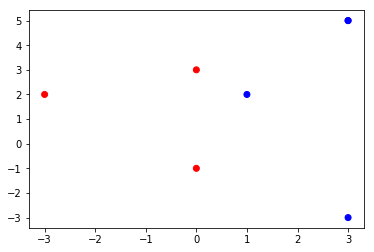

In [9]:
plt.scatter(z_svm[:,0], z_svm[:,1], c=np.where(y_svm>0, ['b'], 'r'))

In [10]:
clf = SVC(C=1e10, kernel='poly', degree=2, gamma=1, coef0=1)
clf.fit(x_svm, y_svm)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=2, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
np.sum(clf.n_support_)

5

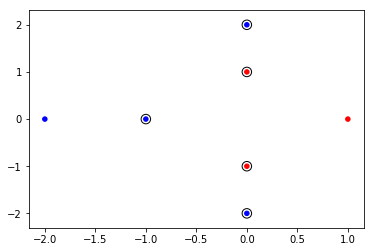

In [12]:
plt.scatter(x_svm[:,0], x_svm[:,1], c=np.where(y_svm>0, ['b'], 'r'), s=20)
plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
            s=90, facecolors='none', edgecolors='k')

In [13]:
def cvx_svm(x, y):
    ATOL = 1e-6
    Z = (1 + x @ x.T)**2
    yT = y[None, :]
    xyz = yT.T * Z
    Q = xyz @ xyz.T
    n = len(Z)
    I = np.ones(n).T
    a_ = Variable(n)
    prob = Problem(Minimize(1/2 * quad_form(a_, Q) - I @ a_),
                   [yT @ a_ == 0, a_ >= 0])
    prob.solve()
    assert prob.status == 'optimal'
    a = np.array(a_.value).squeeze(1)
    cond = np.abs(a) > ATOL
    an, xn, yn = a[cond], x[cond], y[cond]
    ay = an * yn
    w = np.sum(ay[:,None] * xn, axis=0)
    b = 1/yn[0] - w @ xn[0]
    return dict(a=an, y=yn, ay=ay, w=w, b=b, sv=xn, nsv=len(xn))

my_svm = cvx_svm(x_svm, y_svm)
my_svm['sv']

array([[ 0.,  1.],
       [ 0., -1.],
       [-1.,  0.],
       [ 0.,  2.],
       [ 0., -2.]])

In [14]:
np.allclose(clf.support_vectors_, my_svm['sv'])

True

In [15]:
my_svm

{'a': array([ 0.02729,  0.02729,  0.03604,  0.00927,  0.00927]),
 'ay': array([-0.02729, -0.02729,  0.03604,  0.00927,  0.00927]),
 'b': -1.00000,
 'nsv': 5,
 'sv': array([[ 0.,  1.],
        [ 0., -1.],
        [-1.,  0.],
        [ 0.,  2.],
        [ 0., -2.]]),
 'w': array([ -3.60351e-02,  -1.38778e-17]),
 'y': array([-1., -1.,  1.,  1.,  1.])}

# Radial Basis Functions
## Problems 13-18

In [16]:
def rbf_func(x):
    x1, x2 = x[:,0], x[:,1]
    return np.sign(x2 - x1 + .25 * np.sin(np.pi * x1))

def random_points(num=100, vmin=-1., vmax=+1.):
    return np.random.rand(num, 2) * (vmax-vmin) + vmin

def lab2col(lab):
    return mpl.cm.spectral(lab / 10)

def sk_split(x, n):
    clus = KMeans(n).fit(x)
    return clus.cluster_centers_, clus.labels_

def empty_clusters(nc, labels):
    if labels is None:
        return True
    for i in range(nc):
        if np.sum(labels==i) == 0:
            return True
    return False

def my_split(x, nc):
    nx = len(x)
    labels = np.zeros(nx, dtype='int')
    centers = random_points(nc)
    while 1:
        prev = labels.copy()
        dist = lin.norm(x[:,None,:] - centers[None,:,:], axis=2)
        np.argmin(dist, axis=1, out=labels)
        for i in range(nc):
            x_i = x[labels==i]
            if len(x_i) == 0:
                return None, None
            centers[i] = np.mean(x_i, axis=0)
        if np.array_equal(prev, labels):
            return centers, labels

def reg_rbf_weights(x, y, centers, gamma):
    dist2 = lin.norm(x[:,None,:] - centers[None,:,:], axis=2) ** 2
    Z = np.exp(-gamma * dist2)
    return lin.pinv(Z) @ y

def reg_rbf_predict(x, w, centers, gamma):
    dist2 = lin.norm(x[:,None,:] - centers[None,:,:], axis=2) ** 2
    return np.sign(np.exp(-gamma * dist2) @ w)

def err_of(y, y_pred):
    return np.mean(y != y_pred)

def make_sets(n_train=100, n_test=1000):
    x_train = random_points(n_train)
    y_train = rbf_func(x_train)
    x_test = random_points(n_test)
    y_test = rbf_func(x_test)
    return x_train, y_train, x_test, y_test

def sv_sort(sv):
    return sv[np.argsort(sv, axis=0)[:,0]]

## Demos

In [17]:
rbf_x = random_points()
rbf_y = rbf_func(rbf_x)

In [18]:
ncent = 9
gamma = 1.5

In [19]:
reg_centers, reg_labels = my_split(rbf_x, ncent)
assert not empty_clusters(ncent, reg_labels)

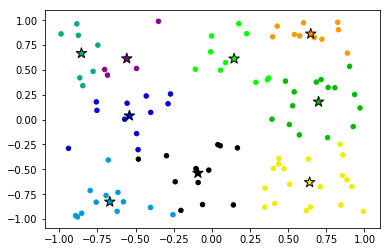

In [20]:
plt.scatter(rbf_x[:,0], rbf_x[:,1], s=20,
            c=[lab2col(l) for l in reg_labels])
plt.scatter(reg_centers[:,0], reg_centers[:,1],
            c=[lab2col(l) for l in range(ncent)],
            marker='*', s=120, edgecolors='k')

In [21]:
reg_w = reg_rbf_weights(rbf_x, rbf_y, reg_centers, gamma)
reg_y = reg_rbf_predict(rbf_x, reg_w, reg_centers, gamma)
reg_err = err_of(rbf_y, reg_y)
reg_err

0.01000

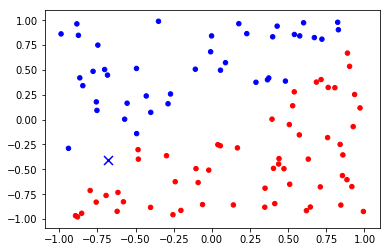

In [22]:
i_ok = np.nonzero(rbf_y == reg_y)[0]
i_bad = np.nonzero(rbf_y != reg_y)[0]
clrs = np.where(rbf_y>0, ['b'], ['r'])
plt.scatter(rbf_x[i_ok,0], rbf_x[i_ok,1], c=clrs[i_ok], marker='o', s=20)
plt.scatter(rbf_x[i_bad,0], rbf_x[i_bad,1], c=clrs[i_bad], marker='x', s=80)

### SKlearn SVM

In [23]:
def skk_fit(x, y, gamma):
    clf = SVC(C=1e10, kernel='rbf', gamma=gamma)
    clf.fit(x, y)
    return clf

def skk_predict(x, clf):
    return clf.predict(x)

skk_clf = skk_fit(rbf_x, rbf_y, gamma)
skk_y = skk_predict(rbf_x, skk_clf)
skk_err = err_of(rbf_y, skk_y)
skk_nsv = skk_clf.n_support_.sum()
skk_sv = skk_clf.support_vectors_
skk_nsv, skk_err

(8, 0.00000)

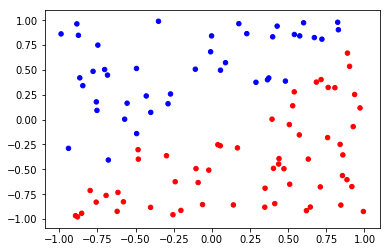

In [24]:
i_ok = np.nonzero(rbf_y == skk_y)[0]
i_bad = np.nonzero(rbf_y != skk_y)[0]
clrs = np.where(rbf_y>0, ['b'], ['r'])
plt.scatter(rbf_x[i_ok,0], rbf_x[i_ok,1], c=clrs[i_ok], marker='o', s=20)
plt.scatter(rbf_x[i_bad,0], rbf_x[i_bad,1], c=clrs[i_bad], marker='x', s=80)

### CVXpy SVM
### TODO: fix svr_fit()

In [25]:
def svr_fit(x, y, gamma):
    ATOL = 1e-5
    n = len(x)
    dist2 = lin.norm(x[:,None,:] - x[None,:,:], axis=2) ** 2
    K = np.exp(-gamma * dist2)
    yT = y[None, :]
    Q = yT * yT.T * K
    I = np.ones(n)
    a_ = Variable(n)
    prob = Problem(Minimize(1/2 * quad_form(a_, Q) - I @ a_),
                   [yT @ a_ == 0, a_ >= 0])
    prob.solve()
    assert prob.status == 'optimal'
    a = np.array(a_.value).squeeze(1)
    cond = np.abs(a) > ATOL
    an, yn, xn = a[cond], y[cond], x[cond]
    return dict(a=an, y=yn, ay = an * yn, sv=xn,
                nsv=len(an), gamma=gamma)

def svr_predict(x, res):
    gamma, ay, sv = res['gamma'], res['ay'], res['sv']
    dist2 = lin.norm(x[:,None,:] - sv[None,:,:], axis=2) ** 2
    K = np.exp(-gamma * dist2)
    return np.sign(K @ ay[:,None]).squeeze(axis=1)

svr_res = svr_fit(rbf_x, rbf_y, gamma)
svr_res

{'a': array([ 34.06215,  14.05916,  10.86179,   5.92921,  23.75464,  46.63797,
         57.55434,  40.21562]),
 'ay': array([-34.06215, -14.05916, -10.86179,   5.92921,  23.75464,  46.63797,
        -57.55434,  40.21562]),
 'gamma': 1.50000,
 'nsv': 8,
 'sv': array([[ 0.53974,  0.27969],
        [-0.79756, -0.7131 ],
        [ 0.88843,  0.66945],
        [ 0.8289 ,  0.90424],
        [-0.493  , -0.14043],
        [-0.67854, -0.40629],
        [-0.48365, -0.30215],
        [ 0.48189,  0.38794]]),
 'y': array([-1., -1., -1.,  1.,  1.,  1., -1.,  1.])}

In [26]:
svr_y = svr_predict(rbf_x, svr_res)
svr_err = err_of(rbf_y, svr_y)
svr_err

0.00000

In [27]:
x_out = random_points(1000)
y_out = rbf_func(x_out)
(err_of(skk_clf.predict(x_out), y_out),
 err_of(svr_predict(x_out, svr_res), y_out),
 err_of(reg_rbf_predict(x_out, reg_w, reg_centers, gamma), y_out))

(0.03800, 0.03700, 0.05300)

### Task 13 - Compare SKLearn (OK) vs CVXpy (Fails a.t.m.)

In [28]:
def task13_pre(niter=100, gamma=1.5):
    nerr_skk = nerr_svr = nwin_skk = nwin_svr = 0
    for i in range(niter):
        x_train, y_train, x_test, y_test = make_sets()
        clf = skk_fit(x_train, y_train, gamma)
        res = svr_fit(x_train, y_train, gamma)
        ein_skk = err_of(skk_predict(x_train, clf), y_train)
        ein_svr = err_of(svr_predict(x_train, res), y_train)
        assert ein_skk >= 0 and ein_svr >= 0
        if ein_skk > 0:
            nerr_skk += 1
        if ein_svr > 0:
            nerr_svr += 1
        eout_skk = err_of(skk_predict(x_test, clf), y_test)
        eout_svr = err_of(svr_predict(x_test, res), y_test)
        assert eout_skk >= 0 and eout_svr >= 0
        if eout_skk < eout_svr:
            nwin_skk += 1
        else:
            nwin_svr += 1
    return nerr_skk, nerr_svr, nwin_skk, nwin_svr

task13_pre()

(0, 37, 71, 29)

## Task 13-15

In [29]:
def run_svm(x_train, y_train, x_test, y_test, gamma, svm):
    assert svm in ('skk', 'svr', 'off')
    big = 999
    if svm == 'off':
        return False, big
    if svm == 'skk':
        clf = skk_fit(x_train, y_train, gamma)
        ein = err_of(skk_predict(x_train, clf), y_train)
    else:
        try:
            res = svr_fit(x_train, y_train, gamma)
        except AssertionError:
            print('oops!')
            return True, big
        ein = err_of(svr_predict(x_train, res), y_train)
    if ein > 0:
        return True, big
    if svm == 'skk':
        eout = err_of(skk_predict(x_test, clf), y_test)
    else:
        eout = err_of(svr_predict(x_test, res), y_test)
    return False, eout

def task_rbf(niter=1000, ncent=9, gamma=1.5, svm=None):
    i = nonsep_cnt = kbeat_cnt = 0
    all_ei_reg, all_eo_reg = [], []

    while i < niter:
        x_train, y_train, x_test, y_test = make_sets()
        centers, labels = my_split(x_train, ncent)
        if empty_clusters(ncent, labels):
            continue
        erf, eo_svm = run_svm(x_train, y_train, x_test, y_test, gamma, svm)
        if erf > 0:
            nonsep_cnt += 1
            continue
        w = reg_rbf_weights(x_train, y_train, centers, gamma)
        reg_train = reg_rbf_predict(x_train, w, centers, gamma)
        reg_test = reg_rbf_predict(x_test, w, centers, gamma)
        ei_reg = err_of(reg_train, y_train)
        eo_reg = err_of(reg_test, y_test)

        all_ei_reg.append(ei_reg)
        all_eo_reg.append(eo_reg)
        if eo_svm < eo_reg:
            kbeat_cnt += 1
        i += 1

    return dict(svm=svm, niter=i,
                ei_reg=np.mean(all_ei_reg)*100,
                eo_reg=np.mean(all_eo_reg)*100,
                nonsep_pc=nonsep_cnt/i*100,
                kbeat_pc=kbeat_cnt/i*100)

#### Task 13-15 (SKlearn)

In [30]:
task_rbf(niter=2000, ncent=9, svm='skk')

{'ei_reg': 3.60250,
 'eo_reg': 5.53645,
 'kbeat_pc': 87.65000,
 'niter': 2000,
 'nonsep_pc': 0.00000,
 'svm': 'skk'}

In [31]:
task_rbf(niter=5000, ncent=12, svm='skk')

{'ei_reg': 2.25300,
 'eo_reg': 4.43712,
 'kbeat_pc': 77.82000,
 'niter': 5000,
 'nonsep_pc': 0.00000,
 'svm': 'skk'}

#### Task 13-15 (CVX)

In [32]:
task_rbf(niter=500, ncent=9, svm='svr')

{'ei_reg': 3.44800,
 'eo_reg': 5.72720,
 'kbeat_pc': 82.60000,
 'niter': 500,
 'nonsep_pc': 65.80000,
 'svm': 'svr'}

In [33]:
task_rbf(niter=500, ncent=12, svm='svr')

{'ei_reg': 2.08600,
 'eo_reg': 4.56180,
 'kbeat_pc': 74.60000,
 'niter': 500,
 'nonsep_pc': 61.20000,
 'svm': 'svr'}

## Task 16-18

In [34]:
def task_reg_rbf(niter, ncent1, ncent2, gamma1, gamma2):
    i = nonsep_cnt = 0
    ei_up_cnt = ei_dn_cnt = eo_up_cnt = eo_dn_cnt = 0
    ei1_0_cnt = ei2_0_cnt = 0
    all_ei1, all_eo1 = [], []
    all_ei2, all_eo2 = [], []

    while i < niter:
        x_train, y_train, x_test, y_test = make_sets()
        centers1, labels1 = my_split(x_train, ncent1)
        if empty_clusters(ncent1, labels1):
            continue
        centers2, labels2 = my_split(x_train, ncent2)
        if empty_clusters(ncent2, labels2):
            continue
        w1 = reg_rbf_weights(x_train, y_train, centers1, gamma1)
        w2 = reg_rbf_weights(x_train, y_train, centers2, gamma2)
        reg1_train = reg_rbf_predict(x_train, w1, centers1, gamma1)
        reg2_train = reg_rbf_predict(x_train, w2, centers2, gamma2)
        reg1_test = reg_rbf_predict(x_test, w1, centers1, gamma1)
        reg2_test = reg_rbf_predict(x_test, w2, centers2, gamma2)
        ei1 = err_of(reg1_train, y_train)
        ei2 = err_of(reg2_train, y_train)
        eo1 = err_of(reg1_test, y_test)
        eo2 = err_of(reg2_test, y_test)

        all_ei1.append(ei1)
        all_ei2.append(ei2)
        all_eo1.append(eo1)
        all_eo2.append(eo2)

        if ei2 > ei1:  ei_up_cnt += 1
        if ei2 < ei1:  ei_dn_cnt += 1
        if eo2 > eo1:  eo_up_cnt += 1
        if eo2 < eo1:  eo_dn_cnt += 1
        if ei1 == 0:   ei1_0_cnt += 1
        if ei2 == 0:   ei2_0_cnt += 1

        i += 1

    return dict(niter=i,
                ei1=np.mean(all_ei1)*100,
                eo1=np.mean(all_eo1)*100,
                ei2=np.mean(all_ei2)*100,
                eo2=np.mean(all_eo2)*100,
                ei_up_pc=ei_up_cnt/i*100,
                ei_dn_pc=ei_dn_cnt/i*100,
                eo_up_pc=eo_up_cnt/i*100,
                eo_dn_pc=eo_dn_cnt/i*100,
                ei1_0_pc=ei1_0_cnt/i*100,
                ei2_0_pc=ei2_0_cnt/i*100,)

#### Task 16

In [35]:
task_reg_rbf(niter=2000, ncent1=9, ncent2=12, gamma1=1.5, gamma2=1.5)

{'ei1': 3.61900,
 'ei1_0_pc': 2.70000,
 'ei2': 2.25150,
 'ei2_0_pc': 9.50000,
 'ei_dn_pc': 65.60000,
 'ei_up_pc': 13.55000,
 'eo1': 5.49550,
 'eo2': 4.40275,
 'eo_dn_pc': 74.00000,
 'eo_up_pc': 24.10000,
 'niter': 2000}

#### Task 17

In [36]:
task_reg_rbf(niter=4000, ncent1=9, ncent2=9, gamma1=1.5, gamma2=2)

{'ei1': 3.64225,
 'ei1_0_pc': 2.90000,
 'ei2': 4.08250,
 'ei2_0_pc': 1.67500,
 'ei_dn_pc': 30.22500,
 'ei_up_pc': 46.70000,
 'eo1': 5.59690,
 'eo2': 6.06100,
 'eo_dn_pc': 38.05000,
 'eo_up_pc': 59.70000,
 'niter': 4000}

#### Task 18 ???

In [37]:
task_reg_rbf(niter=4000, ncent1=9, ncent2=9, gamma1=1.5, gamma2=1.5)

{'ei1': 3.63800,
 'ei1_0_pc': 2.77500,
 'ei2': 3.62775,
 'ei2_0_pc': 3.32500,
 'ei_dn_pc': 36.67500,
 'ei_up_pc': 36.60000,
 'eo1': 5.54830,
 'eo2': 5.57563,
 'eo_dn_pc': 47.82500,
 'eo_up_pc': 49.70000,
 'niter': 4000}

-----